In [22]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

In [23]:
#Parameters
w=pd.read_excel("Datos_Bosa.xlsx", sheet_name="W_grb", index_col=0)
Prc=pd.read_excel("Datos_Bosa.xlsx", sheet_name="Prc_grb", index_col=0)
DistanciaA=pd.read_excel("Datos_Bosa.xlsx", sheet_name="Distancia_grb", index_col=0)
D=pd.read_excel("Datos_Bosa.xlsx", sheet_name="D_grb", index_col=0)
#Scalar
betaP = -2.0  # Weight factor price
betaD = -0.5  # Weight factor distance
F = 10        # Máximo de mercados callejeros

min_val = DistanciaA.min().min()
max_val = DistanciaA.max().max()
Dis = (DistanciaA - min_val) / (max_val - min_val)
Prc_matrix = np.tile(Prc.values.flatten(), (Dis.shape[1], 1)).T
V = betaD * Dis + betaP * Prc_matrix

# Convertir V a DataFrame de pandas
V_df = pd.DataFrame(V, index=np.arange(1, Dis.shape[0] + 1))
A_aux = DistanciaA <= 0.5
A= A_aux.astype(int)

# Calcular exp(V) * A para el rango de índices superior e inferior
exp_V_A_top = np.exp(V_df.iloc[:25]) * A.iloc[:25]
exp_V_A_bottom = np.exp(V_df.iloc[25:70]) * A.iloc[25:70]

# Sumar exp(V) * A a lo largo de las filas para cada columna en el rango inferior
sum_exp_V_A_bottom = exp_V_A_bottom.sum(axis=0)

# Calcular PHI usando broadcasting para dividir cada elemento del numerador por el sumatorio correspondiente
PHI = exp_V_A_top.divide(sum_exp_V_A_bottom, axis=1)


In [24]:
markets=Prc.index.tolist() #Markets
market_candidates=w.index.tolist() #Possible street markets
competitors= list(range(26, 71)) #Competitors

customer= D.index.tolist() #Customer
days=D.columns.tolist() #Days

In [25]:
#Creando modelo
model = gp.Model('Facility Location - Street Markets')
model.setParam(GRB.Param.MIPGap, 0.0)

Set parameter MIPGap to value 0


In [26]:
#Variables
x=model.addVars([(i,t) for i in market_candidates for t in days], vtype=GRB.BINARY, name="x") # 1 if the location of street market i is selected in period t - 0 otherwise 
y=model.addVars([(i,j,t) for i in market_candidates for j in customer for t in days],lb=0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="y") #The probability of household j of selecting street market i at period t
yb=model.addVars([(j,t) for j in customer for t in days],lb=0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS,name="yb")

In [27]:
#F.O.
model.setObjective(gp.quicksum(w.loc[i,"Weight"] * D.loc[j, t] *y[i, j, t] for i in market_candidates for j in customer for t in days), GRB.MAXIMIZE)

#R1
for i in market_candidates:
    for t in days:  # Asegurarse de no salirse del rango de los días al hacer t+2
        if t <= len(days) - 2:  # Para asegurar que t+2 esté dentro del rango
            model.addConstr(x[i, t] + x[i, t+1] + x[i, t+2] <= 1, name=f"R1_{i}_{t}")

        

#R2
for i in market_candidates:
    model.addConstr(x[i, 1] + x[i, 2] + x[i, 7] <= 1, name=f"R2_{i}")

#R3
model.addConstr(gp.quicksum(x[i, t] for i in market_candidates for t in days) == F, name="R3")

#R4
for j in customer:
    for t in days:
        model.addConstr(yb[j, t] + gp.quicksum(y[i, j, t] for i in market_candidates) <= 1, name=f"R4_{j}_{t}")

#R5 and R6
for i in market_candidates:
    for j in customer:
        for t in days:
            model.addConstr(y[i, j, t] - (PHI.loc[i, j] / (1 + PHI.loc[i, j])) * x[i, t] <= 0, name=f"R5_{i}_{j}_{t}")
            model.addConstr(y[i, j, t] - PHI.loc[i, j] * yb[j, t] <= 0, name=f"R6_{i}_{j}_{t}")

#R7
for t in range(1, 6):  # Asumiendo que los días están numerados del 1 al 7
    model.addConstr(gp.quicksum(x[i, t] for i in market_candidates) >= 0.1 * F, name=f"R7_{t}")



In [28]:
model.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 3450U with Radeon Vega Mobile Gfx, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96903 rows, 49497 columns and 146266 nonzeros
Model fingerprint: 0x35784b99
Variable types: 49322 continuous, 175 integer (175 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+26]
  Objective range  [4e+00, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective -0.0000000
Presolve removed 94766 rows and 48013 columns
Presolve time: 0.06s
Presolved: 2137 rows, 1484 columns, 4747 nonzeros
Variable types: 1309 continuous, 175 integer (175 binary)
Found heuristic solution: objective 579.6839101

Root relaxation: objective 7.269149e+02, 203 iteration

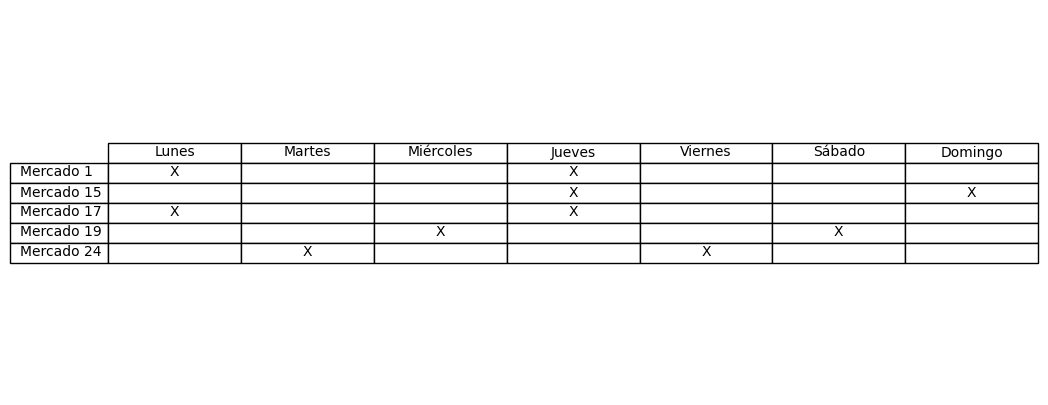

In [29]:
days_of_week = {
    1: "Lunes",
    2: "Martes",
    3: "Miércoles",
    4: "Jueves",
    5: "Viernes",
    6: "Sábado",
    7: "Domingo"
}

df = pd.DataFrame(columns=[days_of_week[i] for i in range(1, 8)])

for i in market_candidates:
    row = {day: '' for day in days_of_week.values()}  
    for t in days:
        if x[i, t].x == 1:
            row[days_of_week[t]] = 'X' 
    
    if 'X' in row.values():
        df.loc[f'Mercado {i}'] = row 

fig, ax = plt.subplots(figsize=(10, 5))  
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2) 

plt.show()


In [30]:
for i in market_candidates:
    for t in days:
        print("Mercado",i,"en el día",t, x[i, t].x)

Mercado 1 en el día 1 1.0
Mercado 1 en el día 2 0.0
Mercado 1 en el día 3 0.0
Mercado 1 en el día 4 1.0
Mercado 1 en el día 5 0.0
Mercado 1 en el día 6 0.0
Mercado 1 en el día 7 0.0
Mercado 2 en el día 1 0.0
Mercado 2 en el día 2 0.0
Mercado 2 en el día 3 0.0
Mercado 2 en el día 4 0.0
Mercado 2 en el día 5 0.0
Mercado 2 en el día 6 0.0
Mercado 2 en el día 7 0.0
Mercado 3 en el día 1 0.0
Mercado 3 en el día 2 0.0
Mercado 3 en el día 3 0.0
Mercado 3 en el día 4 0.0
Mercado 3 en el día 5 0.0
Mercado 3 en el día 6 0.0
Mercado 3 en el día 7 0.0
Mercado 4 en el día 1 0.0
Mercado 4 en el día 2 0.0
Mercado 4 en el día 3 0.0
Mercado 4 en el día 4 0.0
Mercado 4 en el día 5 0.0
Mercado 4 en el día 6 0.0
Mercado 4 en el día 7 0.0
Mercado 5 en el día 1 0.0
Mercado 5 en el día 2 0.0
Mercado 5 en el día 3 0.0
Mercado 5 en el día 4 0.0
Mercado 5 en el día 5 0.0
Mercado 5 en el día 6 0.0
Mercado 5 en el día 7 0.0
Mercado 6 en el día 1 0.0
Mercado 6 en el día 2 0.0
Mercado 6 en el día 3 0.0
Mercado 6 en